In [1]:
import torch

# Check if CUDA (GPU) is available
print("Is CUDA available?", torch.cuda.is_available())

# If available, print device name
if torch.cuda.is_available():
    print("GPU Device:", torch.cuda.get_device_name(0))


Is CUDA available? True
GPU Device: NVIDIA GeForce RTX 4060 Laptop GPU


Import necessary libraries

In [2]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader


Extract MFCC features

In [3]:
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

def extract_features(file_path,max_len=174):
    # Load audio file
    audio, sample_rate = librosa.load(file_path, sr=22050)
    # Extract 40 MFCC features
    mfcc=librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    # Normalize the MFCCs
    mfcc=(mfcc - np.mean(mfcc)) / np.std(mfcc)
    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
    return mfcc # 2D array of shape(40, time)

features = []
labels = []
emotion_counts = defaultdict(int)#Track counts per emotion

for root, _, files in os.walk('Emotionalspeech'):
    for file in files:
        if file.endswith('.wav'):
            try:
                emotion_code = file.split('-')[2]
                if emotion_code in emotion_map:
                    label = emotion_map[emotion_code]
                    file_path = os.path.join(root, file)
                    mfcc = extract_features(file_path)

                    if mfcc.shape == (40, 174):
                        features.append(mfcc)
                        labels.append(label)
                        emotion_counts[label] += 1
            except Exception as e:
                print(f"Error processing file: {file} → {e}")

# Print count summary
print("Files loaded per emotion:")
for emo in sorted(emotion_counts):
    print(f"{emo:>10}: {emotion_counts[emo]}")


Files loaded per emotion:
     angry: 384
      calm: 384
   disgust: 384
   fearful: 384
     happy: 384
   neutral: 192
       sad: 384
 surprised: 384


Label encode

In [4]:
#convert emotion labels from string to numbers
le=LabelEncoder()
encoded_labels=le.fit_transform(labels)

print("Classes:", le.classes_)
print("Encoded labels:", encoded_labels[:20])


Classes: ['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']
Encoded labels: [5 5 5 5 1 1 1 1 1 1 1 1 4 4 4 4 4 4 4 4]


Creating train_test split

In [5]:
X = np.array(features)
y = np.array(encoded_labels)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (2304, 40, 174)
Test shape: (576, 40, 174)


Building PyTorch model

Defining a Custom Dataset Class

In [6]:
class EmotionDataset(Dataset):
    def __init__(self,X,y): #Stores data as tensors
        self.X=torch.tensor(X, dtype=torch.float32)
        self.y=torch.tensor(y, dtype=torch.long) #labels
        
    def __len__(self): #Returns number of samples
        return len(self.X)
        
    def __getitem__(self,idx): #Returns one (feature, label) pair
        return self.X[idx].unsqueeze(0), self.y[idx] #unsqueeze(0)adds a new dimension at 0th position, turning it into a 3D tensor with 1 channel.


Creating Datasets & DataLoaders

In [7]:
train_dataset=EmotionDataset(X_train, y_train)
test_dataset=EmotionDataset(X_test, y_test)

train_loader=DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Building a CNN model

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F


In [9]:
class EmotionCNN(nn.Module): #defining a custom neural network called EmotionCNN
    def __init__(self, numclasses):
        super(EmotionCNN, self).__init__()

        #1st convolutional layer
        self.conv1=nn.Conv2d(1,16,kernel_size=3, padding=1) #1 input channel, 16 output filters, 3x3 kernel,padding ensuring spatial size stays same
        self.bn1=nn.BatchNorm2d(16) #normalize each of the 16 feature maps independently across the batch
        self.pool1=nn.MaxPool2d(2) #reduces the size of the feature maps by taking the maximum value in small windows
        
        #2nd convolutional layer
        self.conv2=nn.Conv2d(16,32,kernel_size=3, padding=1)
        self.bn2=nn.BatchNorm2d(32)
        self.pool2=nn.MaxPool2d(2)
        
        #3nd convolutional layer
        self.conv3=nn.Conv2d(32,64,kernel_size=3, padding=1)
        self.bn3=nn.BatchNorm2d(64)
        self.pool3=nn.MaxPool2d(2)
        
        #fully connected layer
        self.fc1=nn.Linear(64*5*21, 128) #converts extracted features into a 128-length vector 
        self.dropout=nn.Dropout(0.3) #Randomly disables 30% of neurons, preventing overfitting
        self.fc2=nn.Linear(128,numclasses) #maps the 128-dimensional output to the number of emotion classes 
        
    def forward(self,x):
        x=self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)  #flattening each feature map into a single long vector (.view() reshapes tensors)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x
        

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [11]:
model = EmotionCNN(numclasses=8)
model.to(device)


EmotionCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6720, out_features=128, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=8, bias=True)
)

In [12]:
import torch.optim as optim

criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(), lr=0.0005)


Training Loop

In [13]:
num_of_epoch=40
for epoch in range(num_of_epoch):
    model.train()
    running_loss=0
    correct=0
    total=0
    for inputs,labels in train_loader:
        inputs=inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad() #clear previous gradients
        outputs=model(inputs) #forward pass
        loss=criterion(outputs, labels)
        loss.backward() #backpropagation
        optimizer.step() #updating weights
        
        running_loss+=loss.item() #.item() gives scalar (float) value
        _,predicted=torch.max(outputs.data, 1)  #gets predicted class labels
        total+=labels.size(0)
        correct+=(predicted == labels).sum().item()
        
    acc=100*correct/total
    print(f"Epoch [{epoch+1}/{num_of_epoch}]-Loss:{running_loss:.4f}-Accuracy:{acc:.2f}%")
        

    

Epoch [1/40]-Loss:137.0146-Accuracy:26.78%
Epoch [2/40]-Loss:113.8608-Accuracy:39.45%
Epoch [3/40]-Loss:100.4020-Accuracy:46.44%
Epoch [4/40]-Loss:87.1676-Accuracy:55.73%
Epoch [5/40]-Loss:74.3108-Accuracy:62.07%
Epoch [6/40]-Loss:65.7423-Accuracy:67.93%
Epoch [7/40]-Loss:60.3005-Accuracy:68.92%
Epoch [8/40]-Loss:51.8738-Accuracy:74.05%
Epoch [9/40]-Loss:42.1686-Accuracy:80.03%
Epoch [10/40]-Loss:35.2303-Accuracy:83.81%
Epoch [11/40]-Loss:29.3244-Accuracy:86.81%
Epoch [12/40]-Loss:28.1907-Accuracy:87.37%
Epoch [13/40]-Loss:24.1793-Accuracy:88.85%
Epoch [14/40]-Loss:18.5252-Accuracy:91.58%
Epoch [15/40]-Loss:16.6050-Accuracy:93.49%
Epoch [16/40]-Loss:15.7488-Accuracy:93.66%
Epoch [17/40]-Loss:12.9746-Accuracy:94.88%
Epoch [18/40]-Loss:10.8245-Accuracy:96.09%
Epoch [19/40]-Loss:11.8788-Accuracy:95.10%
Epoch [20/40]-Loss:10.6840-Accuracy:95.62%
Epoch [21/40]-Loss:9.7510-Accuracy:96.35%
Epoch [22/40]-Loss:8.7112-Accuracy:96.22%
Epoch [23/40]-Loss:7.5026-Accuracy:96.92%
Epoch [24/40]-Loss:6

Evaluating on Test Set

In [14]:
model.eval()
correct=0
total=0
all_preds=[]
all_labels=[]
with torch.no_grad():
    for inputs,labels in test_loader:
        inputs,labels=inputs.to(device), labels.to(device)
        outputs=model(inputs)
        _,predicted=torch.max(outputs.data, 1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
test_accuracy=100*correct/total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 96.53%


In [15]:
from sklearn.metrics import classification_report, confusion_matrix
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=le.classes_))


Classification Report:
              precision    recall  f1-score   support

       angry       0.97      0.97      0.97        76
        calm       0.97      1.00      0.99        77
     disgust       0.97      0.95      0.96        77
     fearful       0.95      0.95      0.95        77
       happy       0.91      1.00      0.95        77
     neutral       1.00      1.00      1.00        38
         sad       0.97      0.92      0.95        77
   surprised       1.00      0.95      0.97        77

    accuracy                           0.97       576
   macro avg       0.97      0.97      0.97       576
weighted avg       0.97      0.97      0.97       576



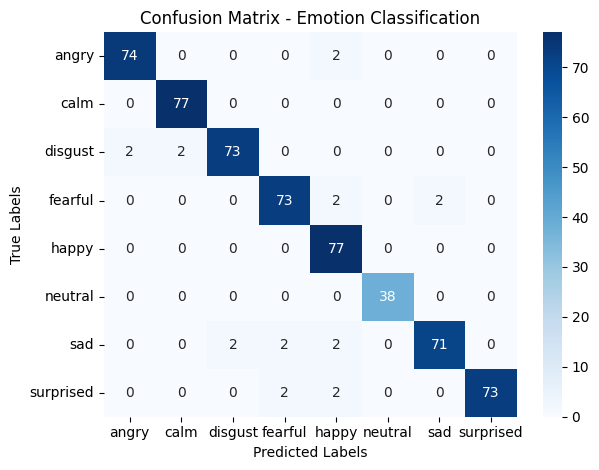

In [16]:
cm=confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d',cmap='Blues',xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Emotion Classification')
plt.tight_layout()
plt.show()

Saving the model

In [17]:
torch.save(model.state_dict(), 'emotion_cnn.pth')